In [2]:
# This defines the zone we are going to explore images for.
ZONE = "south"
# Change this to False to re-download crops as part of this notebook.
CROPS_ALREADY_DOWNLOADED = True

In [3]:
# Load environment variables to download images.
# This defines the following environment variables:
# COPERNICUS_LOGIN, COPERNICUS_PASSWORD, AWS_SECRET_ACCESS_KEY, AWS_ACCESS_KEY_ID
import json
import os

with open("../env_vars.json", "r") as file:
    env_vars = json.load(file)
    for k, v in env_vars.items():
        os.environ[k] = v

In [24]:
%matplotlib inline

import sys
import os
from pathlib import Path
from datetime import datetime

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tsd
import geojson
import json
import folium
import rasterio, rasterio.mask
from PIL import Image, ImageDraw, ImageFont

sys.path.append("../forestry_yield_estimation")
import vistools, utils
from preprocessing import read_images, read_raw_points_data, read_raw_polygons_data, get_catalog, get_aoi
from scraping import load_paysandu_weather

pd.options.mode.chained_assignment = None
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.4)

root = Path("..")
data_path = root / "data"
output_path = Path("../report/img")

In [ ]:
aoi = get_aoi(data_path, ZONE)
aoi_utm = get_aoi(data_path, ZONE, convert_to_utm=True)
aoi

# AOI check
Here we sanity-check the aoi by making sure that:

1. It's in the right place on the map
2. All our measurements lie inside of it

In [182]:
df = read_raw_points_data(data_path)

fm = vistools.foliummap()
folium.GeoJson(aoi).add_to(fm)
fm.location = aoi["center"][::-1]

for _, row in df.query("zone == 'south'").iterrows():
    folium.Marker(row[["lat", "lon"]].tolist()).add_to(fm)

#fm

# Download crops

In [7]:
# Normalization
montenativo = (
    pd.read_csv(data_path/"montenativo.csv")
    .rename(columns=lambda col: f"montenativo_{col.split('_')[0]}" if "backscatter" in col else col)
)
montenativo

date polarisation  montenativo_mean  montenativo_median
0    2017-01-04           vh          2.787902            4.521789
1    2017-01-04           vv          3.109945            5.068904
2    2017-01-16           vh          2.742583            4.430817
3    2017-01-16           vv          3.082033            5.010635
4    2017-01-28           vh          2.622069            4.219508
..          ...          ...               ...                 ...
227  2021-03-08           vv          2.995163            4.867535
228  2021-03-20           vh          2.631642            4.248495
229  2021-03-20           vv          2.993268            4.867535
230  2021-04-01           vh          2.616674            4.219508
231  2021-04-01           vv          2.986692            4.852030

[232 rows x 4 columns]

In [8]:
catalog = get_catalog(data_path, ZONE, download_crops=not CROPS_ALREADY_DOWNLOADED)
catalog["date_str"] = catalog["date"].dt.date.astype("str")
df = montenativo.merge(catalog, left_on=["date", "polarisation"], right_on=["date_str", "polarisation"], suffixes=(None, "_y"))[["date", "polarisation", "montenativo_mean", "montenativo_median", "filename"]]
df["date"] = pd.to_datetime(df["date"])
df

Found 76 images


date polarisation  montenativo_mean  montenativo_median  \
0   2017-01-04           vh          2.787902            4.521789   
1   2017-01-04           vv          3.109945            5.068904   
2   2017-01-16           vh          2.742583            4.430817   
3   2017-01-16           vv          3.082033            5.010635   
4   2017-01-28           vh          2.622069            4.219508   
..         ...          ...               ...                 ...   
117 2018-12-01           vv          3.034001            4.934474   
118 2018-12-13           vh          2.666565            4.276666   
119 2018-12-13           vv          3.041452            4.934474   
120 2018-12-25           vh          2.689497            4.356709   
121 2018-12-25           vv          3.056033            4.976734   

                              filename  
0    2017-01-04_S1B_orbit_170_D_GRD_vh  
1    2017-01-04_S1B_orbit_170_D_GRD_vv  
2    2017-01-16_S1B_orbit_170_D_GRD_vh  
3    2017-01-16_S1B_orbit_170_D_GRD_vv  
4    2017-01-28_S1B_orbit_170_D_GRD_vh  
..                                 ...  
117  2018-12-01_S1B_orbit_170_D_GRD_vv  
118  2018-12-13_S1B_orbit_170_D_GRD_vh  
119  2018-12-13_S1B_orbit_170_D_GRD_vv  
120  2018-12-25_S1B_orbit_170_D_GRD_vh  
121  2018-12-25_S1B_orbit_170_D_GRD_vv  

[122 rows x 5 columns]

In [9]:
raw_images, filenames, srcs = read_images(data_path, ZONE)
images = np.log(raw_images)
is_vv = np.array([f.endswith("vv") for f in filenames])

norm = df["montenativo_mean"].values
images = images - norm.reshape(-1, 1, 1)

images_8bit = np.empty_like(images, dtype="uint8")
images_8bit[is_vv] = utils.simple_equalization_8bit(images[is_vv])
images_8bit[~is_vv] = utils.simple_equalization_8bit(images[~is_vv])

  0%|          | 0/122 [00:00<?, ?it/s]

In [13]:
assert is_vv.sum() == (~is_vv).sum()

images_rgb = np.empty((is_vv.sum(), images.shape[1], images.shape[2], 3))
images_rgb[:, :, :, 0] = raw_images[is_vv] # Channel 1 (R): vv
images_rgb[:, :, :, 1] = raw_images[~is_vv] # Channel 2 (G): vh
images_rgb[:, :, :, 2] = images_rgb[:, :, :, 0] / images_rgb[:, :, :, 1] # Channel 3 (B): vv/vh

images_rgb_8bit = np.empty_like(images_rgb, dtype="uint8")
for channel in range(3):
    images_rgb_8bit[:, :, :, channel] = utils.simple_equalization_8bit(images_rgb[:, :, :, channel], 0.5)

In [10]:
weather = load_paysandu_weather(data_path)
weather.index = weather.index.map(str)
weather_dict = weather.T.to_dict()

In [15]:
images.shape

(122, 372, 588)

# Explore images interactively
You need ipywidgets installed for this to work.

Use the slider to go forwards or backwards in time.

Use the checkbox to compare vv and vh images.

In [11]:
from IPython.display import Image, display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image

def display_image(img_index, vv=True):
    mask = (is_vv == vv)
    display(Image.fromarray(images_8bit[mask][img_index]))
    filename = filenames[mask][img_index]
    display(filename)
    w = weather_dict.get(filename[:10], "No data")
    display(w)

applet = interactive(
    display_image,
    img_index=widgets.IntSlider(min=0, max=58, step=1, value=10, layout=widgets.Layout(width="100%")),
    vv=True
)
applet.layout.height = "550px"
applet

interactive(children=(IntSlider(value=10, description='img_index', layout=Layout(width='100%'), max=58), Check…

In [223]:
def display_image_rgb(img_index):
    display(Image.fromarray(images_rgb_8bit[img_index]))
    display(filenames[is_vv][img_index][:-3])

applet = interactive(
    display_image_rgb,
    img_index=widgets.IntSlider(min=0, max=60, step=1, value=10, layout=widgets.Layout(width="100%")),
)
applet.layout.height = "500px"
applet

interactive(children=(IntSlider(value=10, description='img_index', layout=Layout(width='100%'), max=60), Outpu…

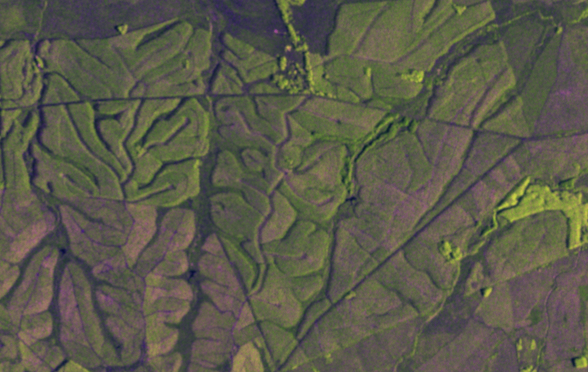

In [14]:
Image.fromarray(images_rgb_8bit.mean(0).round().astype("uint8"))

# Visualize polygons

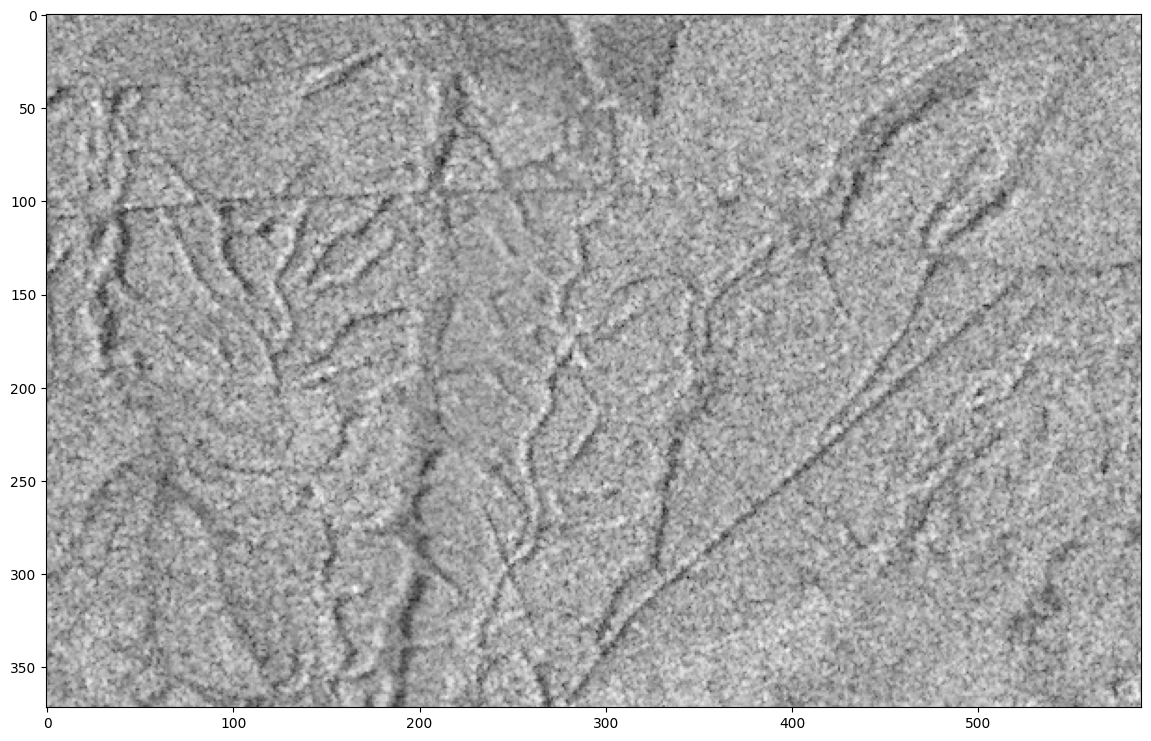

In [36]:
with plt.style.context("default"):
    ratio = images.shape[2] / images.shape[1]
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(images[0], cmap="gray")
    plt.savefig(output_path/"images"/"south_image.png")

In [20]:
polygons, rodals = read_raw_polygons_data(data_path, ZONE)

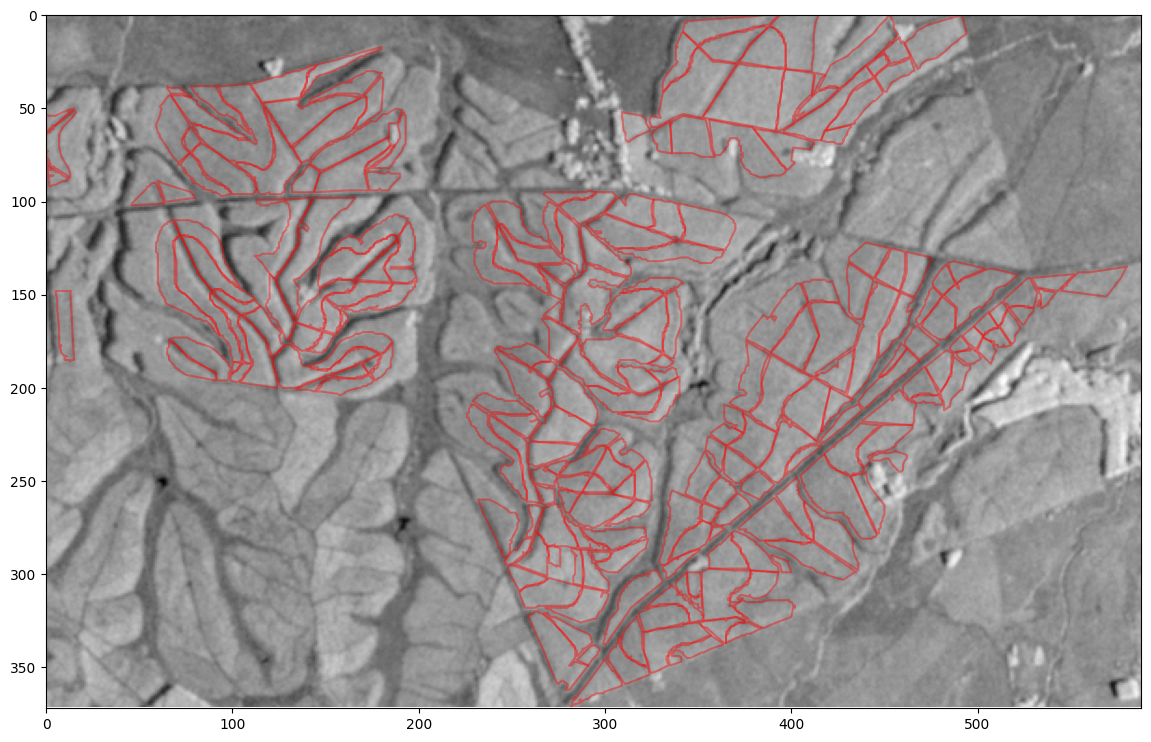

In [37]:
with plt.style.context("default"):
    plt.subplots(figsize=(ratio*9, 9))
    plt.imshow(images.mean(0), cmap="gray")
    
    for polygon in polygons:
        polygon = np.array([
            srcs[1].index(x, y)
            for x, y in polygon[0]
        ])
        plt.plot(polygon[:, 1], polygon[:, 0], c="red", alpha=0.4)
    plt.xlim(0, images.shape[2])
    plt.ylim(images.shape[1], 0)
plt.savefig(output_path/"polygons"/"south_polygons.png")

In [170]:
def display_decalage(dx, dy):
    plt.subplots(figsize=(16, 9))
    plt.imshow(images.mean(0), cmap="gray")
    for polygon in polygons:
        polygon = np.array([
            srcs[1].index(x, y)
            for x, y in polygon[0]
        ]) + np.array([[dx, dy]])
        plt.plot(polygon[:, 1], polygon[:, 0], c="red")
    plt.show()

applet = interactive(
    display_decalage,
    dx=widgets.IntSlider(min=-10, max=10, step=1, layout=widgets.Layout(width="100%")),
    dy=widgets.IntSlider(min=-10, max=10, step=1, layout=widgets.Layout(width="100%")),
)
applet.layout.height = "800px"
applet

interactive(children=(IntSlider(value=0, description='dx', layout=Layout(width='100%'), max=10, min=-10), IntS…

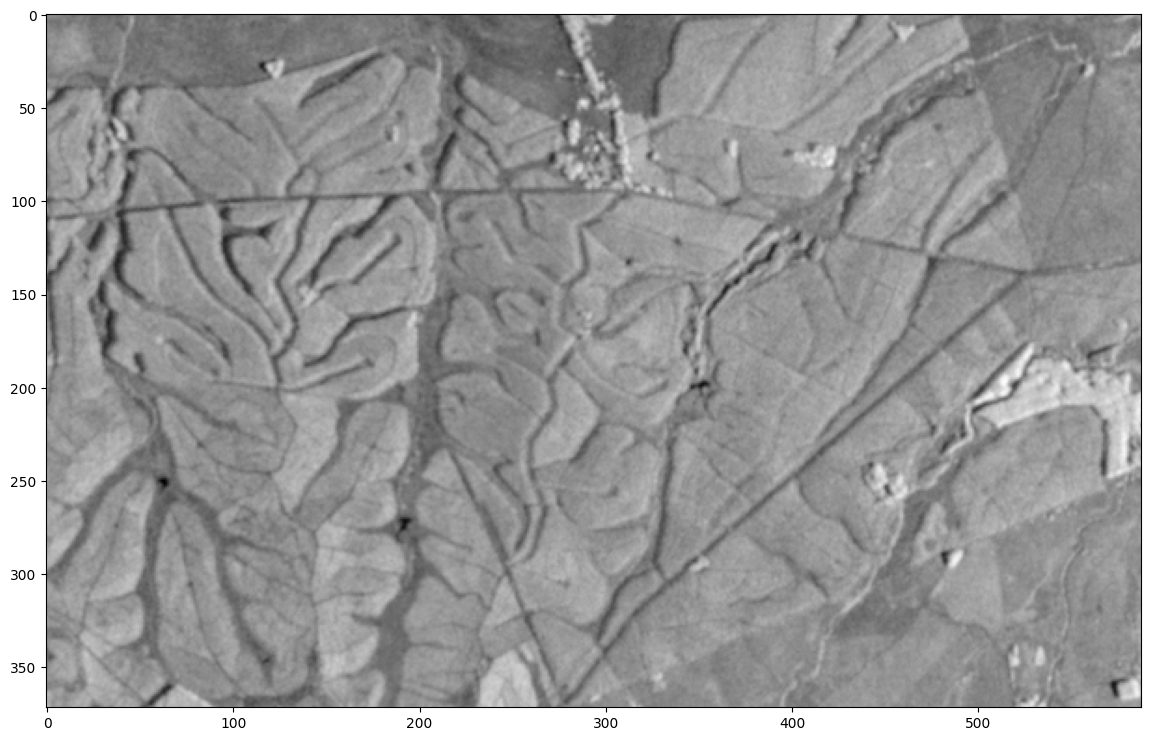

In [152]:
plt.subplots(figsize=(16, 9))
plt.imshow(images.mean(0), cmap="gray")

# Produce gifs

In [ ]:
for polarity in ["vv", "vh"]:
    mask = (is_vv == (polarity == "vv"))
    
    frames = []
    for i, (img, filename) in enumerate(zip(images[mask], filenames[mask])):
        img = Image.fromarray(img)
        frame = Image.new("L", (img.width, img.height+20))
        frame.paste(img)
        fnt = ImageFont.truetype("/usr/share/fonts/truetype/open-sans/OpenSans-Regular.ttf", 20)
        draw = ImageDraw.Draw(frame)

        # Filename
        draw.text((0,img.height-5), filename, font=fnt, fill=255)

        # Progress indicator
        draw.text(
            (test.width - (40 if i < 9 else 51), test.height-5),
            f"{i+1}/{len(images[mask])}",
            font=fnt,
            fill=255
        )

        frames.append(frame)

    frames[0].save(
        fp=viz_path / "gif" / f"{ZONE}_{polarity}.gif",
        format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=400,
        loop=0,
        optimize=True,
    )